# Polling Performance

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Watermark</a></span></li><li><span><a href="#File-locations" data-toc-modified-id="File-locations-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>File locations</a></span></li><li><span><a href="#Plotting-stuff" data-toc-modified-id="Plotting-stuff-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plotting stuff</a></span></li></ul></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span><ul class="toc-item"><li><span><a href="#Final-polling-data" data-toc-modified-id="Final-polling-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Final polling data</a></span></li><li><span><a href="#Latest-AEC-national-count-data" data-toc-modified-id="Latest-AEC-national-count-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Latest AEC national count data</a></span><ul class="toc-item"><li><span><a href="#First-preference-votes-nationally" data-toc-modified-id="First-preference-votes-nationally-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>First preference votes nationally</a></span></li><li><span><a href="#Two-party-preferred-votes-by-state" data-toc-modified-id="Two-party-preferred-votes-by-state-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Two party preferred votes by state</a></span></li></ul></li></ul></li><li><span><a href="#Plots" data-toc-modified-id="Plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#Explore-primary-polls-vs-election-result" data-toc-modified-id="Explore-primary-polls-vs-election-result-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Explore primary polls vs election result</a></span></li><li><span><a href="#Total-absolute-deviation-by-poll" data-toc-modified-id="Total-absolute-deviation-by-poll-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Total absolute deviation by poll</a></span></li><li><span><a href="#Explore-2pp-Polls-vs-Election-Result" data-toc-modified-id="Explore-2pp-Polls-vs-Election-Result-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Explore 2pp Polls vs Election Result</a></span></li></ul></li><li><span><a href="#The-End" data-toc-modified-id="The-End-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Python setup

### Imports

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Patch

# system imports
from pathlib import Path
from io import StringIO
from datetime import datetime
import itertools
import numbers

# local imports
import common

### Watermark

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sat Jun 25 2022 12:36:29

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

numpy     : 1.23.0
pandas    : 1.4.3
matplotlib: 3.5.2

Watermark: 2.3.1



### File locations

In [3]:
CHARTS_DIR = '../charts/'
Path(CHARTS_DIR).mkdir(parents=True, exist_ok=True)

### Plotting stuff

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')
SIGMA = 2
LFOOTER = (
    'Polling data sourced from Wikipedia. '
    'Election data from AEC. '
)
LFOOTER2 = f'Error bars at {SIGMA}-sigma based on effective sample size. '

## Get data

### Final polling data

In [5]:
# https://essentialreport.com.au/wp-content/uploads/2022/05/Essential-Report-Disclosure-Statement-18_05_22-Full-Questionnaire.pdf
# https://www.roymorgan.com/findings/8977-roy-morgan-poll-on-federal-voting-intention-may-2022-202205161214
# https://www.ipsos.com/en-au/afr-ipsos-poll-mark-2022-federal-election
# https://en.wikipedia.org/wiki/Opinion_polling_for_the_2022_Australian_federal_election

poll_data = """
Date,           Firm,              Mode,             Sample, ESS,  L/NP, ALP,  GRN,  ONP, UAP, OTH,  UND, LNP2PP, ALP2PP
13-19 May 2022, Newspoll-YouGov,   Online,           2188,   1505, 35,   36,   12,   5,   3,   9,    -,   47,     53
15-18 May 2022, Ipsos,             Telephone/online, 1996,   1865, 35,   36,   13,   5,   3,   8,    -,   47,     53
12-17 May 2022, Resolve Strategic, Telephone/online, 2049,   -,    34.4, 31.3, 13.5, 5.8, 4.4, 10.5, -,   48.8,   51.2
11-17 May 2022, Essential,         Online,           1599,   1459, 36,   35,   9,    4,   3,   6,    7,   46,     48
9-15 May 2022,  Roy Morgan,        Telephone/online, 1366,   -,    34,   34,   13,   4,   1,   14,   -,   47,     53
"""

primary = {
    'L/NP': 'Coalition', 
    'ALP': 'Labor',   
    'GRN': 'Greens',  
    'ONP': 'One Nation', 
    'UAP': 'United Australia', 
    'OTH': 'Other',
}
tpp = {
    'LNP2PP': 'Coalition', 
    'ALP2PP': 'Labor',
}
polls = pd.read_csv(StringIO(poll_data), skipinitialspace=True, na_values='-')

# Normalise to sum to 100 per cent (primarily because Essential does not distribute undecideds)
polls[list(primary.keys())] = polls[primary.keys()].div(polls[primary.keys()].sum(axis=1), axis=0) * 100
polls[list(tpp.keys())] = polls[tpp.keys()].div(polls[tpp.keys()].sum(axis=1), axis=0) * 100

# use effective sample size if available
polls['ESS'] = polls['ESS'].where(polls['ESS'].notna(), other=polls['Sample'])

# relabel columns
polls = polls.rename(columns=primary)
polls


,Date,Firm,Mode,Sample,ESS,Coalition,Labor,Greens,One Nation,United Australia,Other,UND,LNP2PP,ALP2PP
0,13-19 May 2022,Newspoll-YouGov,Online,2188,1505.0,35.000000,36.000000,12.000000,5.000000,3.000000,9.000000,NaN,47.00000,53.00000
1,15-18 May 2022,Ipsos,Telephone/online,1996,1865.0,35.000000,36.000000,13.000000,5.000000,3.000000,8.000000,NaN,47.00000,53.00000
2,12-17 May 2022,Resolve Strategic,Telephone/online,2049,2049.0,34.434434,31.331331,13.513514,5.805806,4.404404,10.510511,NaN,48.80000,51.20000
3,11-17 May 2022,Essential,Online,1599,1459.0,38.709677,37.634409,9.677419,4.301075,3.225806,6.451613,7.0,48.93617,51.06383
4,9-15 May 2022,Roy Morgan,Telephone/online,1366,1366.0,34.000000,34.000000,13.000000,4.000000,1.000000,14.000000,NaN,47.00000,53.00000


In [6]:
primary_polls_final_mean = polls[primary.values()].mean()
pd.DataFrame(primary_polls_final_mean)#.to_html()

,0
Coalition,35.428822
Labor,34.993148
Greens,12.238187
One Nation,4.821376
United Australia,2.926042
Other,9.592425


In [7]:
tpp_polls_final_mean = polls[tpp.keys()].mean()
pd.DataFrame(tpp_polls_final_mean)#.to_html()

,0
LNP2PP,47.747234
ALP2PP,52.252766


### Latest AEC national count data

#### First preference votes nationally

In [8]:
houseFirstPrefsByParty = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseFirstPrefsByPartyDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
houseFirstPrefsByParty = houseFirstPrefsByParty.set_index(['PartyAb'], drop=True)


In [9]:
# Party groupings
groups = {
    'Coalition': ['LP', 'LNP', 'NP', 'CLP'],
    'Labor': ['ALP'],
    'Greens': ['GRN'],
    'One Nation': ['ON'],
    'United Australia': ['UAPP'],
}
groups['Other'] = (
    list(set(houseFirstPrefsByParty.index.to_list()) 
         - set(itertools.chain.from_iterable(groups.values())))
)

In [10]:
def get_group_totals(data):
    total_votes = data['TotalVotes'].sum()
    primary_tally = {}
    for label, group in groups.items():
        both = list(set(group).intersection(set(data.index)))
        primary_tally[label] = (
            data
            .loc[both, 'TotalVotes']
            .sum() 
            / total_votes * 100
        )
    return pd.Series(primary_tally)

In [11]:
# current state of primary votes
primary_tally = get_group_totals(houseFirstPrefsByParty)
assert primary_tally.sum() == 100.0
pd.DataFrame(primary_tally)#.to_html()

,0
Coalition,35.700382
Labor,32.580778
Greens,12.251721
One Nation,4.962562
United Australia,4.123980
Other,10.380576


#### Two party preferred votes by state

In [12]:
houseTppByState = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseTppByStateDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)

# State name as index - add percent counted to the data
houseTppByState.index = houseTppByState['StateAb']
houseTppByState

,StateAb,StateNm,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing
StateAb,,,,,,,,
NSW,NSW,New South Wales,2259639,48.58,2391301,51.42,4650940,-3.20
VIC,VIC,Victoria,1692372,45.17,2054061,54.83,3746433,-1.69
QLD,QLD,Queensland,1598802,54.05,1359224,45.95,2958026,-4.39
WA,WA,Western Australia,663019,45.00,810206,55.00,1473225,-10.55
SA,SA,South Australia,505274,46.03,592512,53.97,1097786,-3.26
TAS,TAS,Tasmania,159705,45.67,189993,54.33,349698,1.63
ACT,ACT,Australian Capital Territory,93198,33.05,188799,66.95,281997,-5.34
NT,NT,Northern Territory,44872,44.46,56065,55.54,100937,-1.34


In [13]:
labor_tpp_election = (
    houseTppByState['Australian Labor Party Votes'].sum()
    / (houseTppByState['Australian Labor Party Votes'].sum()
       + houseTppByState['Liberal/National Coalition Votes'].sum())
    * 100
)
labor_tpp_election

52.132745100259626

## Plots

### Explore primary polls vs election result

In [14]:
colours = {
    'Coalition': 'blue',
    'Labor': '#dd0000',
    'Greens': 'green',
    'One Nation': 'darkorange',
    'United Australia': 'gold',
    'Other': 'darkorchid',
}

In [15]:
def difference_plot(polls, election, sample_size=None, **kwargs):
    
    compar = polls - election
    colors = kwargs['colors'] if 'colors' in kwargs else 'darkcyan'
    if type(colors) is str:
        colors = pd.Series([colors]*len(compar), index=compar.index)
 
    fig, ax = common.initiate_plot()
    for x, y in compar.iteritems():
        ax.bar(x, y, color=colors[x])
        text = ax.text(x, 0, f'{y:0.1f}', ha='center', va='center',
            fontsize=20)
        text.set_path_effects([pe.withStroke(linewidth=5, foreground='w')])
        
        if sample_size is not None:
            ss = sample_size if isinstance(sample_size, numbers.Number) else sample_size[x]
            p = polls[x] / 100
            z = np.sqrt((p*(1-p))/ss) * 100
            ax.errorbar(x, 0, yerr=SIGMA*z, ecolor='black', capsize=10)
        
    title = kwargs['title'] if 'title' in kwargs else None
    common.plot_finalise(
        ax, 
        title=title, 
        ylabel='Percentage Points', 
        lfooter=LFOOTER + LFOOTER2, 
    )

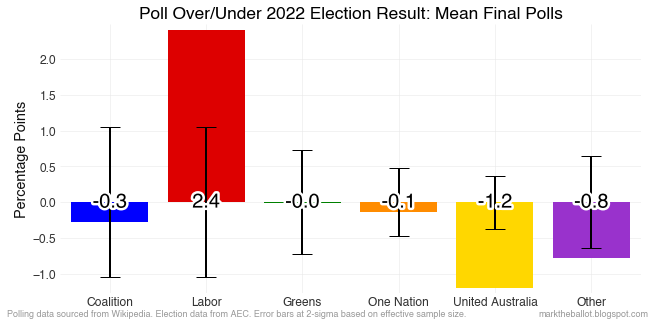

In [16]:
difference_plot(primary_polls_final_mean, primary_tally, 
                polls['ESS'].sum(), 
                colors=colours,
                title='Poll Over/Under 2022 Election Result: Mean Final Polls')

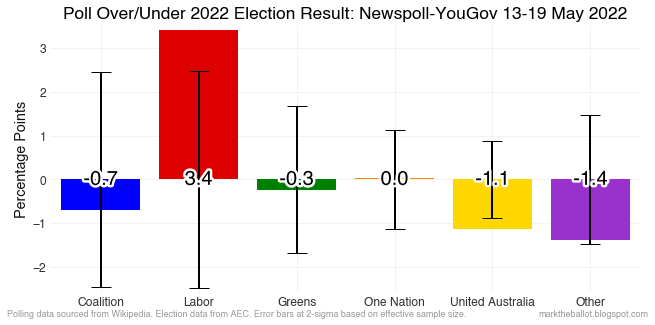

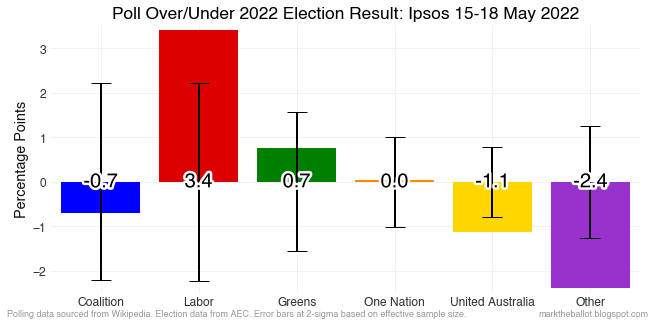

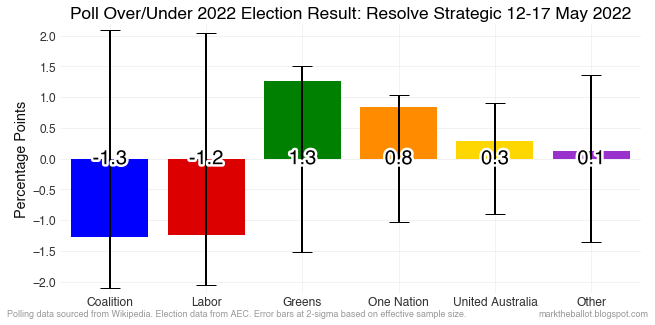

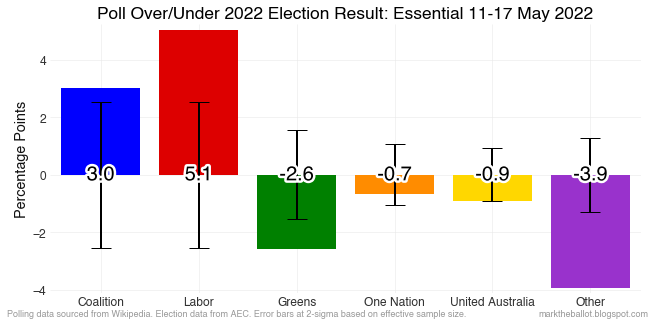

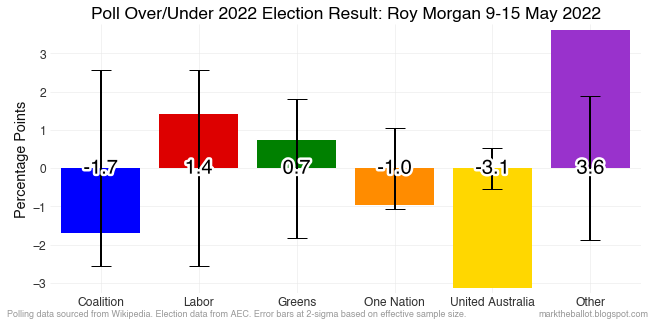

In [17]:
polls.index = polls['Firm'] + ' ' + polls['Date']
for name, poll in polls.iterrows():
    title = f'Poll Over/Under 2022 Election Result: {name}'
    sample_size = poll['ESS']
    difference_plot(poll[primary.values()], primary_tally, 
                    sample_size=sample_size, 
                    colors=colours,
                    title=title)

### Total absolute deviation by poll

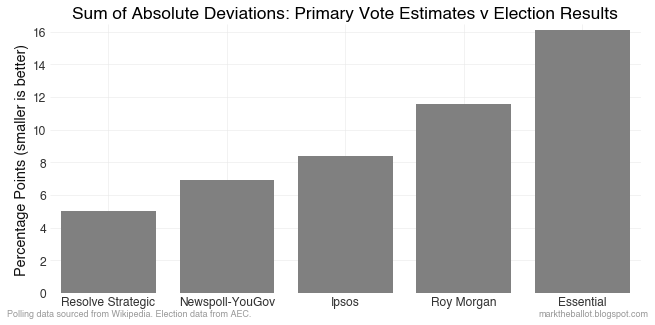

In [18]:
polls.index = polls['Firm']
error = pd.DataFrame(index=polls.index, columns=primary.values())
for column in primary.values():
    error[column] = (polls[column] - primary_tally[column]).abs()
error = error.sum(axis=1).sort_values()

fig, ax = common.initiate_plot()
ax.bar(error.index, error, color='grey')
common.plot_finalise(
        ax, 
        title='Sum of Absolute Deviations: Primary Vote Estimates v Election Results', 
        ylabel='Percentage Points (smaller is better)', 
        lfooter=LFOOTER, 
)

### Explore 2pp Polls vs Election Result

In [19]:
polls['ALP2PP']

Firm
Newspoll-YouGov      53.00000
Ipsos                53.00000
Resolve Strategic    51.20000
Essential            51.06383
Roy Morgan           53.00000
Name: ALP2PP, dtype: float64

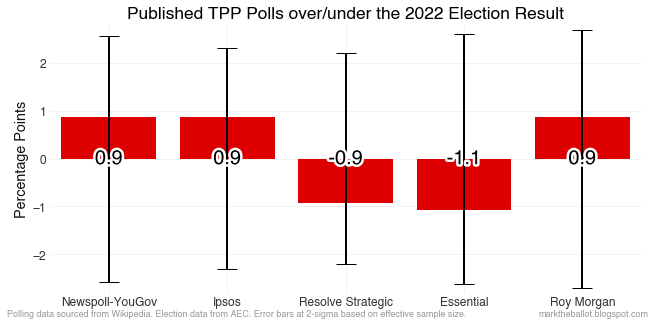

In [20]:
polls.index = polls['Firm']
title = 'Published TPP Polls over/under the 2022 Election Result'
difference_plot(polls['ALP2PP'], 
                labor_tpp_election, 
                sample_size=polls['ESS'], 
                colors='#dd0000',
                title=title,
                lfooter=LFOOTER + LFOOTER2)


## The End

In [21]:
print('Done')

Done
